In [1]:
import pandas as pd
import numpy as np

from completejourney_py import get_data
import bokeh.io
from bokeh.plotting import figure, show
from bokeh.palettes import Category20
from bokeh.transform import factor_cmap
from bokeh.models import Legend
from bokeh.models import ColumnDataSource

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Enable viewing Bokeh plots in the notebook
bokeh.io.output_notebook()


Loading BokehJS ...

# Synopsis
Text

## Computing Environment-Packages Required

In [2]:
%load_ext watermark
%watermark -v -p pandas,jupyterlab,completejourney_py,bokeh

Python implementation: CPython
Python version       : 3.11.3
IPython version      : 8.12.0

pandas            : 1.5.3
jupyterlab        : 3.5.3
completejourney_py: 0.0.3
bokeh             : 3.1.1



## Business Question
We started off by asking: Is there a relationship between household composition (adults vs adults and children) and purchased product?

## Getting Data

In [3]:
cj_data = get_data()

#for loop that iterates over the cj_data dictionary and creates for each data frame that is returned.
for key in cj_data.keys():
    globals()[key]=cj_data[key]
    print(f"Created data frames are as listed: {key}")


Created data frames are as listed: campaign_descriptions
Created data frames are as listed: coupons
Created data frames are as listed: promotions
Created data frames are as listed: campaigns
Created data frames are as listed: demographics
Created data frames are as listed: transactions
Created data frames are as listed: coupon_redemptions
Created data frames are as listed: products


In [4]:
#Find out what keys are shared among the data frames below
print(demographics.columns.intersection(transactions.columns))
print(demographics.columns.intersection(products.columns))
print(products.columns.intersection(transactions.columns))

Index(['household_id'], dtype='object')
Index([], dtype='object')
Index(['product_id'], dtype='object')


In [5]:
#dt_df is the resulting data after merging demographics and transactions and products. excludes records where product type is product type Gasoline-Reg-Unleaded
dt_df=(
    demographics
    .merge(transactions, how='inner', on=['household_id'])
    .merge(products[products['product_type'] != 'GASOLINE-REG UNLEADED'], on=['product_id'])
)
display(dt_df.head())


# ran info method to verify household_comp, kids_count, product_id, and product type had no null values
#dt_df.info()

,household_id,age,income,home_ownership,marital_status,household_size,household_comp,kids_count,store_id,basket_id,...,coupon_disc,coupon_match_disc,week,transaction_timestamp,manufacturer_id,department,brand,product_category,product_type,package_size
0,1,65+,35-49K,Homeowner,Married,2,2 Adults No Kids,0,436,31317046240,...,0.0,0.0,2,2017-01-07 18:55:24,317,GROCERY,National,CHEESE,GRATED CHEESE,8 OZ
1,1020,45-54,25-34K,Homeowner,Married,2,2 Adults No Kids,0,319,31623707351,...,0.0,0.0,5,2017-01-24 21:27:30,317,GROCERY,National,CHEESE,GRATED CHEESE,8 OZ
2,1020,45-54,25-34K,Homeowner,Married,2,2 Adults No Kids,0,319,41453142666,...,0.0,0.0,53,2017-12-31 20:38:39,317,GROCERY,National,CHEESE,GRATED CHEESE,8 OZ
3,1024,25-34,Under 15K,Homeowner,Married,4,2 Adults Kids,2,295,40210715491,...,0.0,0.0,41,2017-10-03 16:26:54,317,GROCERY,National,CHEESE,GRATED CHEESE,8 OZ
4,1070,35-44,50-74K,Homeowner,None,2,2 Adults No Kids,0,401,34032701214,...,0.0,0.0,28,2017-07-09 17:25:08,317,GROCERY,National,CHEESE,GRATED CHEESE,8 OZ


## Analyze the Data

In [6]:
# This code was part of the data cleaning, I was trying to determine if the quantity of items purchased that have a product type of canned cat food was an anomoly.

# filtered_df = dt_df[dt_df['household_comp'] == '1 Adult Kids']
# unique_household_ids = filtered_df['household_id'].nunique()
# display(unique_household_ids)

# cat_filt_df = dt_df[dt_df['product_type'].str.contains('canned cat food', case=False, na=False)& (dt_df['household_comp'] == '1 Adult Kids')]
# cat_filt_df
# cat_filt_df2=(cat_filt_df[['household_id','product_type','household_comp','quantity']])
# grouped_cat_filt_df = cat_filt_df2.groupby('household_id')['quantity'].sum()
# grouped_cat_filt_df 

In [7]:
#show the unique vales in column household_comp
display(dt_df['household_comp'].unique())

#make sure there are no null values in household_comp columns
# dt_df['household_comp'].info()

#count how many transactions there are for each household_comp type
count_by_value = dt_df['household_comp'].value_counts()
count_by_value

array(['2 Adults No Kids', '2 Adults Kids', '1 Adult No Kids',
       '1 Adult Kids'], dtype=object)

2 Adults No Kids    259593
1 Adult No Kids     241746
2 Adults Kids       222559
1 Adult Kids         92913
Name: household_comp, dtype: int64

In [8]:
#groups the dt_df data frame by household_comp and kids count 

grouped_dt_df = (
    dt_df
    .groupby(['household_comp', 'product_type'])
    .agg({'quantity':'sum'})
    .sort_values(by='quantity',ascending=False)
    .reset_index()
)
grouped_dt_df
# takes the returned grouping and finds the top 5 product id's by quantity sum for each household_comp and kids count combination

top_products = grouped_dt_df.groupby(['household_comp']).apply(lambda x: x.nlargest(5, 'quantity')).reset_index(drop=True)


#top_products['product_type'].unique()
top_products.head(15)

,household_comp,product_type,quantity
0,1 Adult Kids,FLUID MILK WHITE ONLY,3564
1,1 Adult Kids,YOGURT NOT MULTI-PACKS,2398
2,1 Adult Kids,SFT DRNK 2 LITER BTL CARB INCL,2235
3,1 Adult Kids,CANNED CAT FOOD (9 LIVES/FRISK,2136
4,1 Adult Kids,SOFT DRINKS 12/18&15PK CAN CAR,1934
5,1 Adult No Kids,FLUID MILK WHITE ONLY,8231
6,1 Adult No Kids,YOGURT NOT MULTI-PACKS,6478
7,1 Adult No Kids,SOFT DRINKS 12/18&15PK CAN CAR,4740
8,1 Adult No Kids,SFT DRNK 2 LITER BTL CARB INCL,4429
9,1 Adult No Kids,CANDY BARS (SINGLES)(INCLUDING,3909


In [9]:
# Pivot the DataFrame
pivoted_df = top_products.pivot(index='household_comp', columns='product_type', values='quantity').fillna(0)

# Reset the index
pivoted_df.reset_index(inplace=True)

# Display the pivoted DataFrame

pivoted_df['Quantity'] = pivoted_df.iloc[:, 1:].sum(axis=1)
display(pivoted_df.head(20))


product_type,household_comp,CANDY BARS (SINGLES)(INCLUDING,CANNED CAT FOOD (9 LIVES/FRISK,FLUID MILK WHITE ONLY,SFT DRNK 2 LITER BTL CARB INCL,SHREDDED CHEESE,SOFT DRINKS 12/18&15PK CAN CAR,YOGURT NOT MULTI-PACKS,Quantity
0,1 Adult Kids,0.0,2136.0,3564.0,2235.0,0.0,1934.0,2398.0,12267.0
1,1 Adult No Kids,3909.0,0.0,8231.0,4429.0,0.0,4740.0,6478.0,27787.0
2,2 Adults Kids,0.0,0.0,8437.0,4451.0,3541.0,4787.0,6950.0,28166.0
3,2 Adults No Kids,4611.0,0.0,9108.0,4033.0,0.0,5796.0,8427.0,31975.0


In [10]:
# Calculate the total quantity for each household composition
total_quantity = pivoted_df.groupby('household_comp')['Quantity'].sum()

# Create a list of unique product types
product_types = top_products['product_type'].unique()

# Create a list of colors for each product type
colors = Category20[20][:len(product_types)]

# Convert total_quantity Series to a DataFrame


# Convert the DataFrame to a ColumnDataSource
source = ColumnDataSource(pivoted_df)

# Define the value columns to stack
value_columns = pivoted_df.columns[1:-1]

#display(value_columns)
value_columns_str=value_columns.astype(str).tolist()


# Initialize the Bokeh figure
p = figure(
    x_range=pivoted_df['household_comp'], 
    frame_height=600, 
    frame_width=1024, 
    title='Quantity by Household Composition'
)

# Create the stacked bar chart
p.vbar_stack(
    value_columns,
    x='household_comp', 
    width=0.7, 
    color=colors,
    legend_label=value_columns_str,
    source=source,
    fill_alpha=0.8)

# Create a dictionary mapping product types to quantity columns

# Add a legend
p.legend.title="Top Product Types"
p.legend.location = "top_left"
p.legend.orientation = "vertical"

# Set axis labels and title
p.xaxis.axis_label = 'Household Composition'
p.yaxis.axis_label = 'Quantity'

tooltips = [
    ("Product Type", "$name"),
    ("Quantity", "@$name{0,0}"),
    
]

hover = bokeh.models.HoverTool(tooltips=tooltips, mode='mouse')
p.add_tools(hover)

# Show the plot
bokeh.io.show(p)

In [11]:
# Calculate the percentage for each column
pivoted_df_percentage = pivoted_df.copy()  # Create a copy of the original DataFrame
value_columns_percentage = pivoted_df_percentage.columns[1:-1]  # Exclude 'product_type' and 'household_comp' columns

# Iterate over the value columns and calculate the percentage for each column
for col in value_columns_percentage:
    pivoted_df_percentage[col] = (pivoted_df_percentage[col] / pivoted_df_percentage['Quantity']) * 100

# Display the modified DataFrame with percentage values
display(pivoted_df_percentage)

product_type,household_comp,CANDY BARS (SINGLES)(INCLUDING,CANNED CAT FOOD (9 LIVES/FRISK,FLUID MILK WHITE ONLY,SFT DRNK 2 LITER BTL CARB INCL,SHREDDED CHEESE,SOFT DRINKS 12/18&15PK CAN CAR,YOGURT NOT MULTI-PACKS,Quantity
0,1 Adult Kids,0.000000,17.41257,29.053558,18.219614,0.000000,15.765876,19.548382,12267.0
1,1 Adult No Kids,14.067730,0.00000,29.621766,15.939108,0.000000,17.058337,23.313060,27787.0
2,2 Adults Kids,0.000000,0.00000,29.954555,15.802741,12.571895,16.995669,24.675140,28166.0
3,2 Adults No Kids,14.420641,0.00000,28.484754,12.612979,0.000000,18.126661,26.354965,31975.0


## Additional Analysis
Milk seems to be roughly 28-30% of overall quantity of items purchase for all house holds compositions.

Do we change our question to show how we can piggy back on milk sales to sell milk related products?

We will just explain how our business question changed as we dug into the data

In [12]:
# Use Regex to filter dt_df dataframe to show product type with fluid milk white only
#Then get the unique basket_id to search transactions that contained milk
pattern = r'fluid milk white only'
filtered_df = dt_df[dt_df['product_type'].str.contains(pattern, case=False, na=False,regex=True)]
basket_ids = filtered_df['basket_id'].unique()


In [13]:
#Filter for all basket_ids that have milk in them to see what other items are sold with milk.

shared_basket_milk = dt_df[dt_df['basket_id'].isin(basket_ids)]

#.copy() used to eliminate SettingWithCopyWarning
shared_basket_milk=shared_basket_milk.copy()



In [14]:
#create total coupon field by summing coupon_disc, and coupon_match_disc. This will allow us to group and see top 5 products purchased with coupons that were also 
#purchased in the same basket with milk.

shared_basket_milk.loc[:, 'total_coupon'] = shared_basket_milk['coupon_disc'] + shared_basket_milk['coupon_match_disc']
display(shared_basket_milk.head())
#shared_basket_milk.columns

,household_id,age,income,home_ownership,marital_status,household_size,household_comp,kids_count,store_id,basket_id,...,coupon_match_disc,week,transaction_timestamp,manufacturer_id,department,brand,product_category,product_type,package_size,total_coupon
7,1154,45-54,35-49K,Homeowner,Married,2,2 Adults No Kids,0,346,40496866024,...,0.0,44,2017-10-26 19:34:14,317,GROCERY,National,CHEESE,GRATED CHEESE,8 OZ,0.0
9,1197,35-44,150-174K,Homeowner,Married,2,2 Adults No Kids,0,384,32231802763,...,0.0,12,2017-03-15 22:55:37,317,GROCERY,National,CHEESE,GRATED CHEESE,8 OZ,0.0
10,1234,45-54,35-49K,Homeowner,Unmarried,2,2 Adults No Kids,0,424,31687473361,...,0.0,6,2017-01-31 01:44:36,317,GROCERY,National,CHEESE,GRATED CHEESE,8 OZ,0.0
12,1234,45-54,35-49K,Homeowner,Unmarried,2,2 Adults No Kids,0,293,34010656969,...,0.0,28,2017-07-08 23:15:41,317,GROCERY,National,CHEESE,GRATED CHEESE,8 OZ,0.0
14,1247,35-44,35-49K,Homeowner,Married,2,2 Adults No Kids,0,374,31883623937,...,0.0,8,2017-02-15 00:26:22,317,GROCERY,National,CHEESE,GRATED CHEESE,8 OZ,0.0


In [15]:
top_product_ids_milk_coupon = (
    shared_basket_milk
    .groupby('product_id')[['total_coupon', 'quantity','sales_value']]
    .sum()
    .nlargest(5, columns=['total_coupon'])
    .reset_index()
)
top_product_ids_milk_coupon

,product_id,total_coupon,quantity,sales_value
0,5569230,92.07,1057,3312.16
1,979674,85.00,35,1254.40
2,5569471,56.95,531,1627.35
3,10118257,55.93,30,206.70
4,5569374,39.50,268,765.60


In [16]:
top_product_ids_milk_nocoup = (
    shared_basket_milk[(shared_basket_milk['product_id'].isin([5569230, 979674, 5569471, 10118257, 5569374])) & (shared_basket_milk['total_coupon'] == 0)]
    .groupby('product_id')[['quantity','sales_value']]
    .sum()
    .sort_values(by='quantity',ascending=False)
    .reset_index()
)
top_product_ids_milk_nocoup

,product_id,quantity,sales_value
0,5569230,931,2980.20
1,5569471,453,1425.97
2,5569374,207,611.85
3,10118257,22,149.18
4,979674,6,215.04


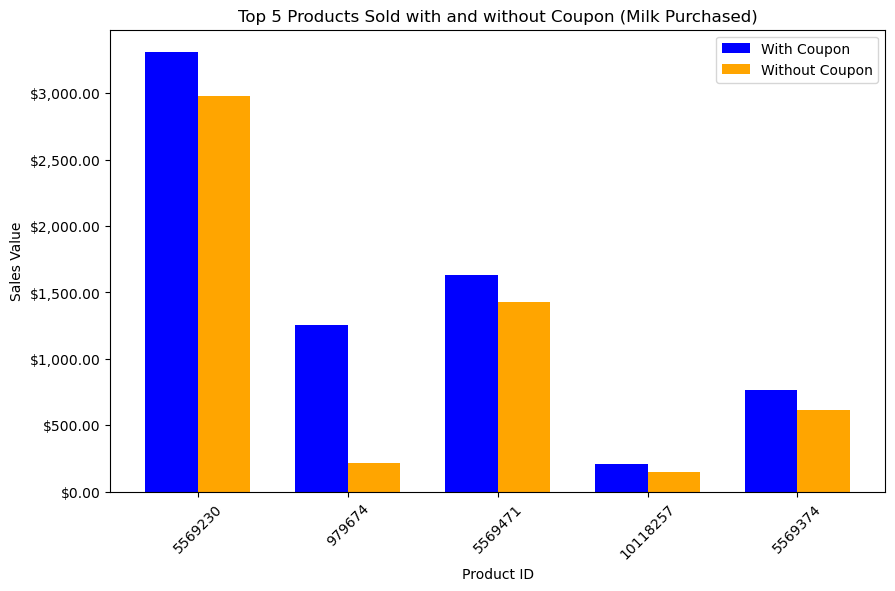

In [17]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(len(top_product_ids_milk_coupon))
r2 = [x + bar_width for x in r1]

# Plot the bar chart for products with coupon
plt.bar(r1, top_product_ids_milk_coupon['sales_value'], color='blue', width=bar_width, label='With Coupon')

# Plot the bar chart for products without coupon
plt.bar(r2, top_product_ids_milk_nocoup.set_index('product_id').loc[top_product_ids_milk_coupon['product_id'], 'sales_value'], color='orange', width=bar_width, label='Without Coupon')

# Set the x-axis ticks and labels
plt.xticks(np.arange(len(top_product_ids_milk_coupon)) + bar_width / 2, top_product_ids_milk_coupon['product_id'])

# Set the y-axis format as dollars with commas
formatter = ticker.StrMethodFormatter('${x:,.2f}')
plt.gca().yaxis.set_major_formatter(formatter)

# Set the title and labels
plt.title('Top 5 Products Sold with and without Coupon (Milk Purchased)')
plt.xlabel('Product ID')
plt.ylabel('Sales Value')

# Set the legend
plt.legend()

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Display the chart
plt.show()



In [18]:
prod_id=979674
filtered_df_prod = dt_df[dt_df['product_id'] == prod_id]
filtered_df_prod.head()
#filtered_df_prod.groupby("age").agg({"sale_value":"sum"})

,household_id,age,income,home_ownership,marital_status,household_size,household_comp,kids_count,store_id,basket_id,...,coupon_disc,coupon_match_disc,week,transaction_timestamp,manufacturer_id,department,brand,product_category,product_type,package_size
746470,1488,25-34,50-74K,Probable Homeowner,Married,2,1 Adult Kids,1,306,36002272805,...,3.0,0.0,38,2017-09-14 13:23:03,111,DRUG GM,National,CIGARETTES,CIGARETTES,CTN
746471,1488,25-34,50-74K,Probable Homeowner,Married,2,1 Adult Kids,1,306,40199016749,...,0.0,0.0,41,2017-10-02 21:18:29,111,DRUG GM,National,CIGARETTES,CIGARETTES,CTN
746472,1488,25-34,50-74K,Probable Homeowner,Married,2,1 Adult Kids,1,306,40889262360,...,0.0,0.0,49,2017-11-27 23:56:36,111,DRUG GM,National,CIGARETTES,CIGARETTES,CTN
746473,1488,25-34,50-74K,Probable Homeowner,Married,2,1 Adult Kids,1,306,41124237157,...,0.0,0.0,50,2017-12-08 23:08:34,111,DRUG GM,National,CIGARETTES,CIGARETTES,CTN
746474,1488,25-34,50-74K,Probable Homeowner,Married,2,1 Adult Kids,1,306,41383257156,...,2.0,0.0,52,2017-12-24 18:57:33,111,DRUG GM,National,CIGARETTES,CIGARETTES,CTN


In [19]:
sales_no_coupon = shared_basket_milk[(shared_basket_milk['product_id'] == 979674) & (shared_basket_milk['total_coupon'] == 0)]
sales_with_coupon = shared_basket_milk[(shared_basket_milk['product_id'] == 979674) & (shared_basket_milk['total_coupon'] > 0)]

sales_by_month_no_coupon = sales_no_coupon.groupby(sales_no_coupon['transaction_timestamp'].dt.month)['sales_value'].sum().reset_index()
sales_by_month_with_coupon = sales_with_coupon.groupby(sales_with_coupon['transaction_timestamp'].dt.month)['sales_value'].sum().reset_index()


#display(sales_no_coupon)
#display(sales_with_coupon)

In [20]:
# Create a Bokeh ColumnDataSource for each line graph
# Convert the Series to DataFrames
sales_by_month_no_coupon = sales_by_month_no_coupon.rename(columns={'sales': 'sales_value'})
sales_by_month_with_coupon = sales_by_month_with_coupon.rename(columns={'sales': 'sales_value'})

# Create a Bokeh ColumnDataSource for each line graph
source_no_coupon = ColumnDataSource(sales_by_month_no_coupon)
source_with_coupon = ColumnDataSource(sales_by_month_with_coupon)

# Create a figure
p = figure(
    x_axis_label='Month', 
    y_axis_label='Sales', 
    frame_height=600, 
    frame_width=1024, 
    title='Sales by Month for Product 979674, When Purchased with Milk')

# Add line graphs
p.line(x='transaction_timestamp', y='sales_value', source=source_no_coupon, line_color='blue', legend_label='No Coupon')
p.line(x='transaction_timestamp', y='sales_value', source=source_with_coupon, line_color='red', legend_label='With Coupon')

# Add legend
p.legend.location = 'top_right'

# Show the plot
bokeh.io.show(p)